In [1]:
using Pkg; Pkg.activate(@__DIR__);

  Activating project at `~/Research/internal_waves_Oceananigans`


In [2]:
Pkg.status()

Status `~/Research/internal_waves_Oceananigans/Project.toml`
  [052768ef] CUDA v4.2.0
  [13f3f980] CairoMakie v0.10.4
  [e9467ef8] GLMakie v0.8.4
  [9e8cae18] Oceananigans v0.81.1 `https://github.com/CliMA/Oceananigans.jl.git#ncc/dont-hardcode-halo-points`


In [3]:
using Oceananigans,
      Oceananigans.Units
using CUDA

[ Info: Oceananigans will use 6 threads


In [4]:
Nx, Nz = 300, 80

architecture = CPU()

const H  = 2kilometers
Lx = 1600kilometers

underlying_grid = RectilinearGrid(architecture,
                                  size = (Nx, Nz),
                                  x = (-Lx/2, Lx/2),
                                  z = (-H, 0),
                                  halo = (4, 4), # start with this commented out
                                  topology = (Periodic, Flat, Bounded))

300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

Now we want to create a bathymetry as an immersed boundary grid.

$$
h(x) = -H + h_0 \, \exp(-x^2 / 2\sigma^2)
$$

In [5]:
const h₀ = 50 # m
const width = 5kilometers
bump(x, y) = - H + h₀ * exp(-x^2 / 2width^2)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bump))

300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── immersed_boundary: GridFittedBottom(min(h)=-2.00e+03, max(h)=-1.96e+03)
├── underlying_grid: 300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

In [6]:
using GLMakie
Makie.inline!(true);

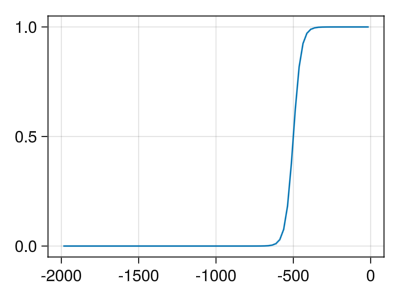

In [7]:
z = znodes(grid, Center());

fig = Figure(resolution=(400, 300))
ax = Axis(fig[1, 1])
lines!(ax, z, @. 1/2 + 1/2 * tanh((z + H/4)/50))

fig

In [8]:
xC = xnodes(grid, Center())

bottom = CUDA.@allowscalar collect(grid.immersed_boundary.bottom_height[1:Nx, 1]);

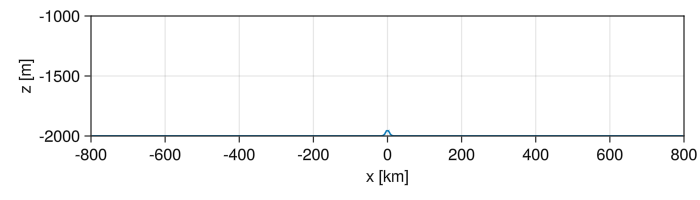

In [9]:
fig = Figure(resolution = (700, 200))
ax = Axis(fig[1, 1],
          xlabel="x [km]",
          ylabel="z [m]",
          limits=((-Lx/2e3, Lx/2e3), (-H, -H/2)))

lines!(ax, xC/1e3, bottom)

fig

The $M_2$ tidal forcing. We add forcing in the $u$-momentum equation of the form:

$$
\partial_t u = \dots + f_0 \cos(\omega_2 t)
$$

In [10]:
const T₂ = 12.421hours
const ω₂ = 2π / T₂ # radians/sec

0.00014051439111137024

The excursion parameter is a nondimensional number that expresses the ratio of the flow movement due to the tide compared to the size of the width of the hill.

$$
\varepsilon = \frac{U / \omega}{\sigma}
$$

In [11]:
coriolis = FPlane(latitude = -45)

FPlane{Float64}(f=-0.000103126)

In [12]:
coriolis.f

-0.00010312607931384282

In [13]:
ε = 0.2

U_tidal = ε * ω₂ * width

coriolis = FPlane(latitude = -45)

const tidal_forcing_amplitude = U_tidal * (coriolis.f^2 - ω₂^2) / ω₂

@inline tidal_forcing(x, y, z, t) = tidal_forcing_amplitude * cos(ω₂ * t)

tidal_forcing (generic function with 1 method)

In [14]:
tidal_timescale = 1 / ω₂

Δt = 0.02 * tidal_timescale

@show prettytime(Δt)

prettytime(Δt) = "2.372 minutes"


"2.372 minutes"

In [15]:
using Oceananigans.Models.HydrostaticFreeSurfaceModels: FFTImplicitFreeSurfaceSolver

fft_preconditioner = FFTImplicitFreeSurfaceSolver(grid)
free_surface = ImplicitFreeSurface(solver_method=:PreconditionedConjugateGradient, preconditioner=fft_preconditioner);

In [16]:
const ν = 5000
@inline variable_viscosity(x, y, z, t) = ν * (1/2 + 1/2 * tanh((z + H/4) / 50))

horizontal_closure = HorizontalScalarDiffusivity(ν=variable_viscosity, κ = variable_viscosity)

HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=variable_viscosity (generic function with 1 method), κ=variable_viscosity (generic function with 1 method))

In [17]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO(),
                                    closure = (horizontal_closure,),
                                    forcing = (u = tidal_forcing,))

HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Tuple with 1 closure:
│   └── HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=variable_viscosity (generic function with 1 method), κ=(b=variable_viscosity (generic function with 1 method),))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: PCGImplicitFreeSurfaceSolver
└── coriolis: FPlane{Float64}

In [18]:
stop_time = 6T₂

simulation = Simulation(model, Δt=Δt, stop_time=stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 2.372 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 3.105 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [19]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)

    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹, next Δt: %s\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

simulation.callbacks[:print_progress] = Callback(print_progress, IterationInterval(200))

Callback of print_progress on IterationInterval(200)

## Diagnostics

There are no predefine diagnostics in Oceananigans! Instead users are expected to construct their own using normal algebraic operations and calculus!

Each model has velocities and some tracers, like buoyancy $b$ or temperature and salinity ($T$ and $S$).

Let's create a few!

In [20]:
b = model.tracers.b
u, v, w = model.velocities

NamedTuple with 3 Fields on 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── u: 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── v: 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
└── w: 300×1×81 Field{Center, Center, Face} on ImmersedBoundaryGrid on CPU

In [21]:
U = Field(Average(u))

u′ = u - U

BinaryOperation at (Face, Center, Center)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    - at (Face, Center, Center)
    ├── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    └── 1×1×1 Field{Nothing, Nothing, Nothing} reduced over dims = (1, 2, 3) on ImmersedBoundaryGrid on CPU

The buoyancy frequency $N^2 = \partial_z b$:

In [22]:
N² = ∂z(b)

Derivative at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU

The velocity vertical shear squared, $S^2 = (\partial_z u)^2 + (\partial_z v)^2$:

In [23]:
S² = @at (Center, Center, Face) ∂z(u)^2 + ∂z(v)^2

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    + at (Center, Center, Face)
    ├── ^ at (Center, Center, Face)
    │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
    │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    │   └── 2
    └── ^ at (Center, Center, Face)
        ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
        │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
        └── 2

And the Richardson number, $Ri = N^2 / S^2$.

In [24]:
Ri = N² / S²

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    / at (Center, Center, Face)
    ├── ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    │   └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
    └── + at (Center, Center, Face)
        ├── ^ at (Center, Center, Face)
        │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
        │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
        │   └── 2
        └── ^ at (Center, Center, Face)
            ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
            │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
            └── 2

In [25]:
name = "barotropic_tide"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; Ri, N², u′, u, w, b),
                                                      schedule = TimeInterval(15minutes),
                                                      with_halos = false,
                                                      filename = name,
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(15 minutes):
├── filepath: ./barotropic_tide.jld2
├── 6 outputs: (Ri, N², u′, u, w, b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

## Initial conditions

In [26]:
# Initial conditions
uᵢ(x, y, z) = U_tidal

Nᵢ² = 4e-5  # [s⁻²] initial buoyancy frequency / stratification
bᵢ(x, y, z) = Nᵢ² * z

set!(model, u=uᵢ, b=bᵢ)

In [27]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 34.589 seconds, max|w|: 6.587e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info:     ... simulation initialization complete (11.877 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (19.955 seconds).
[ Info: iteration: 200, time: 7.158 hours, wall time: 50.136 seconds, max|w|: 1.344e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 400, time: 14.290 hours, wall time: 17.861 seconds, max|w|: 7.248e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 600, time: 21.448 hours, wall time: 17.782 seconds, max|w|: 1.069e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 800, time: 1.191 days, wall time: 17.923 seconds, max|w|: 1.119e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1000, time: 1.489 days, wall time: 17.914 seconds, max|w|: 8.572e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1200, time: 1.786 days, wall time: 17.826 seconds, max|w|: 6.185e-0

## Reading output + visualise

Now we can load the output and visualise.

In [28]:
saved_output_filename = name * ".jld2"

u_t  = FieldTimeSeries(saved_output_filename, "u")
u′_t = FieldTimeSeries(saved_output_filename, "u′")
w_t  = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

times = u_t.times

299-element Vector{Float64}:
      0.0
    900.0
   1800.0
   2700.0
   3600.0
   4500.0
   5400.0
   6300.0
   7200.0
   8100.0
   9000.0
   9900.0
  10800.0
      ⋮
 258300.0
 259200.0
 260100.0
 261000.0
 261900.0
 262800.0
 263700.0
 264600.0
 265500.0
 266400.0
 267300.0
 268200.0

Fields live on different parts of the grid. The information is stored within each field so Oceananigans.jl gives us functionality to get the grid points where each field lives -- we don't need to do it by hand.

In [29]:
xu,  yu,  zu  = nodes(u_t[1])
xw,  yw,  zw  = nodes(w_t[1])
xN², yN², zN² = nodes(N²_t[1])

([-797333.3333333334, -792000.0, -786666.6666666666, -781333.3333333334, -776000.0, -770666.6666666666, -765333.3333333334, -760000.0, -754666.6666666666, -749333.3333333334  …  749333.3333333334, 754666.6666666666, 760000.0, 765333.3333333334, 770666.6666666666, 776000.0, 781333.3333333334, 786666.6666666666, 792000.0, 797333.3333333334], StepRangeLen(1.0, 0.0, 1), [-2000.0, -1975.0, -1950.0, -1925.0, -1900.0, -1875.0, -1850.0, -1825.0, -1800.0, -1775.0  …  -225.0, -200.0, -175.0, -150.0, -125.0, -100.0, -75.0, -50.0, -25.0, 0.0])

In [30]:
using Oceananigans.ImmersedBoundaries: mask_immersed_field!

function mask_and_get_interior(φ_t, n)
    mask_immersed_field!(φ_t[n], NaN)
    return interior(φ_t[n], :, 1, :)
end

mask_and_get_interior (generic function with 1 method)

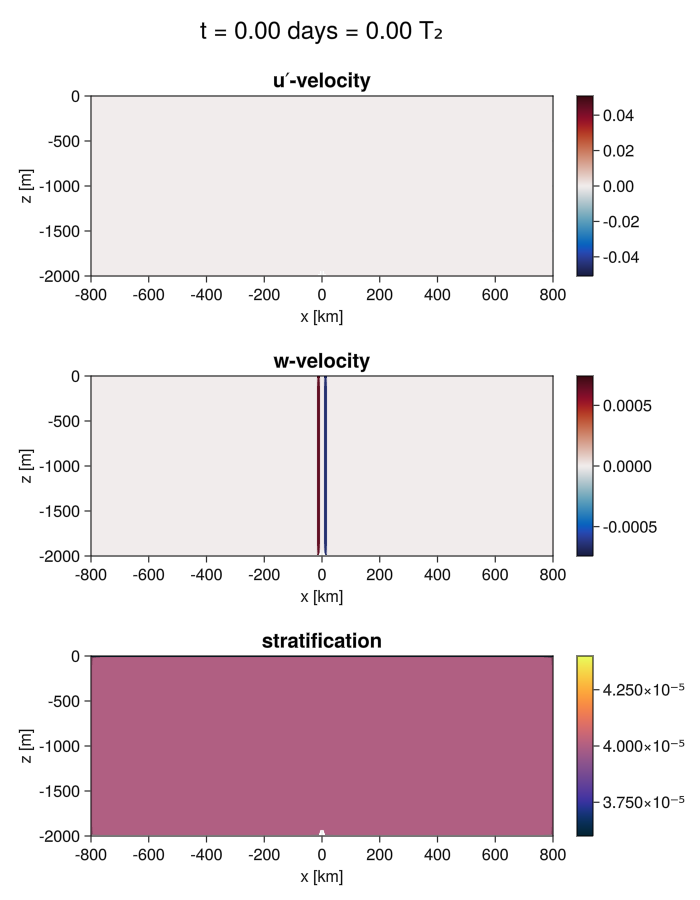

In [31]:
n = Observable(1)

title = @lift @sprintf("t = %1.2f days = %1.2f T₂", round(times[$n]/day, digits=2) , round(times[$n]/T₂, digits=2))

u′ₙ = @lift mask_and_get_interior(u′_t, $n)
wₙ  = @lift mask_and_get_interior(w_t, $n)
N²ₙ = @lift mask_and_get_interior(N²_t, $n)

axis_kwargs = (xlabel = "x [km]",
               ylabel = "z [m]",
               limits = ((-Lx/2e3, Lx/2e3), (-H, 0)),
               titlesize = 20)

ulim   = 0.5 * maximum(abs, u_t[end])
wlim   = maximum(abs, w_t[end])

fig = Figure(resolution = (700, 900))

ax_u = Axis(fig[2, 1];
            title = "u′-velocity", axis_kwargs...)

ax_w = Axis(fig[3, 1];
            title = "w-velocity", axis_kwargs...)

ax_N² = Axis(fig[4, 1];
             title = "stratification", axis_kwargs...)

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

hm_u = heatmap!(ax_u, xu/1e3, zu, u′ₙ;
                colorrange = (-ulim, ulim),
                colormap = :balance)
Colorbar(fig[2, 2], hm_u)

hm_w = heatmap!(ax_w, xw/1e3, zw, wₙ;
                colorrange = (-wlim, wlim),
                colormap = :balance)
Colorbar(fig[3, 2], hm_w)

hm_N² = heatmap!(ax_N², xN²/1e3, zN², N²ₙ;
                 colorrange = (0.9Nᵢ², 1.1Nᵢ²),
                 colormap = :thermal)
Colorbar(fig[4, 2], hm_N²)

fig

In [32]:
@info "Making an animation from saved data..."

frames = 1:length(times)

GLMakie.record(fig, name * ".mp4", frames, framerate=24) do i
    msg = string("Plotting frame ", i, " of ", frames[end])
    print(msg * " \r")
    n[] = i
end

[ Info: Making an animation from saved data...


"barotropic_tide.mp4"